C:\Users\bc-techs\AppData\Local\Temp\ipykernel_26340\905145723.py:89: RuntimeWarning: invalid value encountered in multiply
  intersection_points = ray_origins[:, np.newaxis, :] + t[..., np.newaxis] * ray_directions[:, np.newaxis, :]
C:\Users\bc-techs\AppData\Local\Temp\ipykernel_26340\905145723.py:110: RuntimeWarning: invalid value encountered in divide
  segment_unit_vector = segment_vector / segment_length[:, np.newaxis]


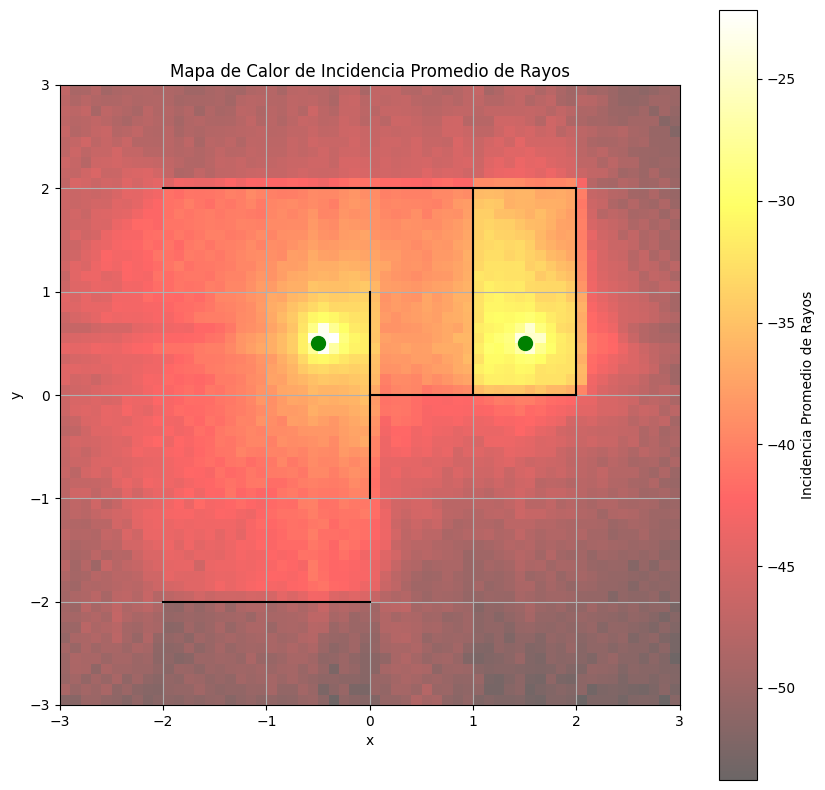

In [87]:
import numpy as np
import math
from typing import List
from models.manager_model import ONTPosition
import matplotlib.pyplot as plt

class SimulationService:
    def __init__(self):
        self.NUM_RAYS = 360
        self.NUM_REFLECTIONS = 3
        self.MAX_DISTANCE = 1000  # Ajustado para escala de píxeles

    def process_geojson(self, geojson_data):
        walls = []
        for feature in geojson_data['features']:
            geometry = feature['geometry']
            if geometry['type'] == 'Polygon':
                walls.extend(self.polygon_to_lines(geometry['coordinates'][0]))
            elif geometry['type'] == 'LineString':
                walls.extend(self.linestring_to_lines(geometry['coordinates']))
        return walls

    def polygon_to_lines(self, polygon):
        return [np.array([polygon[i], polygon[i+1]]) for i in range(len(polygon)-1)]

    def linestring_to_lines(self, linestring):
        return [np.array([linestring[i], linestring[i+1]]) for i in range(len(linestring)-1)]

    def generate_rays(self, origin, walls_points):
        angles = np.linspace(0, 2 * np.pi, self.NUM_RAYS, endpoint=False)
        directions = np.column_stack((np.cos(angles), np.sin(angles)))

        all_rays = []

        for i in range(self.NUM_RAYS):
            ro = origin
            rd = directions[i]
            amplitude = 1.0

            ray_segments = []
            last_wall_index = -1

            for _ in range(self.NUM_REFLECTIONS + 1):
                end_point = ro + self.MAX_DISTANCE * rd

                intersection_points, valid_intersections, t, wall_normals = self.collider(walls_points, np.array([ro]), np.array([rd]))

                if last_wall_index != -1:
                    valid_intersections[0][last_wall_index] = False

                valid_points = intersection_points[0][valid_intersections[0]]
                valid_t = t[0][valid_intersections[0]]

                if len(valid_points) > 0:
                    nearest_index = np.argmin(valid_t)
                    nearest_point = valid_points[nearest_index]
                    nearest_normal = wall_normals[valid_intersections[0]][nearest_index]

                    ray_segments.append((amplitude, ro, nearest_point))

                    continuation_amplitude = amplitude * 0.5
                    continuation_end_point = nearest_point + self.MAX_DISTANCE * rd
                    ray_segments.append((continuation_amplitude, nearest_point, continuation_end_point))

                    ro = nearest_point
                    rd = rd - 2 * np.dot(rd, nearest_normal) * nearest_normal
                    amplitude *= 0.75

                    last_wall_index = np.where(valid_intersections[0])[0][nearest_index]
                else:
                    ray_segments.append((amplitude, ro, end_point))
                    break

            all_rays.extend(ray_segments)

        return all_rays

    def collider(self, walls_points, ray_origins, ray_directions):
        wall_vectors = walls_points[:, 1] - walls_points[:, 0]
        wall_normals = np.column_stack((-wall_vectors[:, 1], wall_vectors[:, 0]))
        wall_normals = wall_normals / np.linalg.norm(wall_normals, axis=1)[:, np.newaxis]

        diff_points = walls_points[:, 0] - ray_origins[:, np.newaxis, :]

        numerator = np.einsum('ijk,jk->ij', diff_points, wall_normals)
        denominator = np.einsum('ij,kj->ik', ray_directions, wall_normals) 

        with np.errstate(divide='ignore', invalid='ignore'):
            t = np.where(denominator != 0, numerator / denominator, np.inf)

        intersection_points = ray_origins[:, np.newaxis, :] + t[..., np.newaxis] * ray_directions[:, np.newaxis, :]

        wall_lengths = np.linalg.norm(wall_vectors, axis=1)
        wall_directions = wall_vectors / wall_lengths[:, np.newaxis]

        relative_positions = intersection_points - np.expand_dims(walls_points[:, 0], axis=0)
        projections = np.einsum('ijk,jk->ij', relative_positions, wall_directions)

        valid_intersections = (projections >= 0) & (projections <= wall_lengths) & (t >= 0)

        return intersection_points, valid_intersections, t, wall_normals

    def point_to_segment_distance_vectorized(self, points, segments):
        segment_start, segment_end = segments[:, 0], segments[:, 1]
        segment_vector = segment_end - segment_start
        point_vector = points[:, np.newaxis, :] - segment_start[np.newaxis, :, :]

        segment_length = np.linalg.norm(segment_vector, axis=1)
        segment_unit_vector = segment_vector / segment_length[:, np.newaxis]

        projection_length = np.einsum('ijk,jk->ij', point_vector, segment_unit_vector)
        projection_length_clipped = np.clip(projection_length, 0, segment_length)
        projection_point = segment_start + projection_length_clipped[:, :, np.newaxis] * segment_unit_vector

        valid_projection = (projection_length >= 0) & (projection_length <= segment_length)
        distance_to_segment = np.where(valid_projection, np.linalg.norm(points[:, np.newaxis, :] - projection_point, axis=2), np.inf)

        pasada_por_punto = np.where(distance_to_segment < 0.1, 1, np.inf)

        return pasada_por_punto 

    def calculate_incidence(self, origin, grid_points, walls_points):
        all_rays = self.generate_rays(origin, walls_points)

        ray_segments = np.array([(start, end) for _, start, end in all_rays])
        amplitudes = np.array([amplitude for amplitude, _, _ in all_rays])

        distances = self.point_to_segment_distance_vectorized(grid_points, ray_segments)

        incidence = np.sum(amplitudes / distances, axis=1)
        power = 0.2
        incidence = (np.power(incidence / np.max(incidence), power) - 1) * 90

        return incidence

    def run_simulation(self, geojson_data, onts: List[ONTPosition], scale):
        self.walls_points = self.process_geojson(geojson_data)
        
        all_coords = np.vstack(self.walls_points)
        min_x, min_y = np.min(all_coords, axis=0)
        max_x, max_y = np.max(all_coords, axis=0)

        resolution = 10  # Ajustar según necesidad
        x_values = np.arange(min_x, max_x, resolution)
        y_values = np.arange(min_y, max_y, resolution)
        grid_x, grid_y = np.meshgrid(x_values, y_values)
        grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

        heatmap_data = []
        total_incidence = np.zeros_like(grid_points[:, 0])
        
        for ont in onts:
            origin = np.array([ont.x, ont.y])
            incidence = self.calculate_incidence(origin, grid_points, self.walls_points)
            total_incidence += incidence

        average_incidence = total_incidence / len(onts)

        for point, incidence in zip(grid_points, average_incidence):
            heatmap_data.append({
                'lng': float(point[0]),
                'lat': float(point[1]),
                'value': float(incidence)
            })

        return {
            'heatmapData': heatmap_data,
            'geoJsonData': geojson_data,
            'onts': [{'serial': ont.serial, 'x': ont.x, 'y': ont.y} for ont in onts]
        }

    def allocate_wifi_channels(self, onts: List[ONTPosition]):
        channels = [1, 6, 11]  # Canales no superpuestos en 2.4 GHz
        allocation = []
        for i, ont in enumerate(onts):
            channel = channels[i % len(channels)]
            allocation.append({
                'serial': ont.serial,
                'x': ont.x,
                'y': ont.y,
                'channel': channel,
                'status': 'Online',
                'connectedClients': np.random.randint(0, 10),
                'signalStrength': np.random.randint(-80, -30)
            })
        return allocation


In [41]:
np.min(distances)


0.0017916212709646606